In [2]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

$\frac{\partial u}{\partial t} = D_u \frac{\partial ^2 u}{\partial x^2} + \alpha u - \beta u v$

$\frac{\partial v}{\partial t} = D_v \frac{\partial ^2 v}{\partial x^2} + \delta u v - \gamma v$

$u(x = 0, t) = v(x = L, t) = 0$

$u(x, t = 0) = (u_0, v_0)$ #This can change

$y = [u,v]^T$

$
A = 
\begin{bmatrix}
D_u L + \alpha I & 0 \\
0 & D_v L - \gamma I
\end{bmatrix}
$

$
g(y,t) = 
\begin{bmatrix}
-\beta(t) (u \odot v) \\
\delta(t) (u \odot v)
\end{bmatrix}
$

$f(y,t) = \dot y = Ay + g(y)$


In [3]:
def laplacian(u, dx):
    N = len(u)
    Lu = np.zeros_like(u)

    Lu[1:-1] = (u[:-2] - 2*u[1:-1] + u[2:]) / dx**2
    Lu[0]    = (0 - 2*u[0] + u[1]) / dx**2
    Lu[-1]   = (u[-2] - 2*u[-1] + 0) / dx**2

    return Lu

def build_laplacian(dx, n):
    M = np.zeros((n,n))
    for i in range(n):
        M[i,i] = -2
        if i > 0:
            M[i,i-1] = 1
        if i < n-1:
            M[i-1,i] = 1
    return M/dx**2


def f(y0, dx, t, alpha=1.0, beta=0.02, delta=0.02, gamma=1.0, D_u=0.01, D_v=0.01):
    u, v = y0
    du = D_u*laplacian(u,dx) + alpha*u - beta*u*v
    dv = D_v*laplacian(v,dx) - gamma*v + delta*u*v
    return du, dv

def rk4(f, delta_t, y, dx, t):
    def add_2state(y1, y2, y1_mult=1, y2_mult=1):
        return y1_mult*y1[0]+y2_mult*y2[0], y1_mult*y1[1]+y2_mult*y2[1]
    k1 = f(y, dx, t)
    k2 = f(add_2state(y, k1, y2_mult=0.5*delta_t),dx, t + delta_t/2)
    k3 = f(add_2state(y, k2, y2_mult=0.5*delta_t),dx, t + delta_t/2)
    k4 = f(add_2state(y, k3, y2_mult=delta_t),dx, t+delta_t)
    total_k = add_2state(add_2state(k1, k4), add_2state(k2,k3, y1_mult=2, y2_mult=2))
    return add_2state(y, total_k, y2_mult=delta_t/6)

def trapezoid(f_curr, delta_t, y, dx, t, A_package): #f_curr is f above ^
    lhs_u, lhs_v, beta, delta = A_package

    u,v = y

    u_dot,v_dot = f_curr(y, dx, t)

    u_guess, v_guess = u + delta_t*u_dot, v + delta_t*v_dot

    g_u = -beta*(u_guess*v_guess)
    g_v = delta*(u_guess*v_guess)

    rhs_u = u + (delta_t/2)*(u_dot + g_u)
    rhs_v = v + (delta_t/2)*(v_dot + g_v)

    return (solve_banded((1,1),lhs_u, rhs_u), solve_banded((1,1),lhs_v, rhs_v))

def solve_IBVP(y0, N, dt, L, T, iterator):
    x = np.linspace(0,L, N+1)
    dx = x[1] - x[0]
    u_tot, v_tot = y0
    u_int, v_int = u_tot[1:-1], v_tot[1:-1]
    U = [(u_int, v_int)]

    # This block is to optimize trapezoid method
    alpha, gamma, D_u, D_v, beta, delta = 1.0,1.0,0.01,0.01,0.02,0.02
    A_u = D_u*build_laplacian(dx, N-1) + np.eye(N-1)*alpha
    A_v = D_v*build_laplacian(dx, N-1) - np.eye(N-1)*gamma
    lhs_u = (np.eye(N-1) - (dt/2)*A_u)
    lhs_v = (np.eye(N-1) - (dt/2)*A_v)

    def dense_tridiagonal_to_banded(A):
        N = A.shape[0]
        ab = np.zeros((3, N))

        ab[0, 1:]  = np.diag(A,  1)   
        ab[1, :]   = np.diag(A,  0)   
        ab[2, :-1] = np.diag(A, -1)   

        return ab

    A_package = (dense_tridiagonal_to_banded(lhs_u), dense_tridiagonal_to_banded(lhs_v), beta, delta)
    #######################

    t = 0.0
    while t < T:
        y_k0 = U[-1]
        dt_step = min(dt, T-t)
        if dt_step != dt:
            dt = dt_step
            alpha, gamma, D_u, D_v, beta, delta = 1.0,1.0,0.01,0.01,0.02,0.02
            A_u = D_u*build_laplacian(dx, N-1) + np.eye(N-1)*alpha
            A_v = D_v*build_laplacian(dx, N-1) - np.eye(N-1)*gamma
            lhs_u = (np.eye(N-1) - (dt/2)*A_u)
            lhs_v = (np.eye(N-1) - (dt/2)*A_v)

            def dense_tridiagonal_to_banded(A):
                N = A.shape[0]
                ab = np.zeros((3, N))

                ab[0, 1:]  = np.diag(A,  1)   
                ab[1, :]   = np.diag(A,  0)   
                ab[2, :-1] = np.diag(A, -1)   

                return ab

            A_package = (dense_tridiagonal_to_banded(lhs_u), dense_tridiagonal_to_banded(lhs_v), beta, delta)
        y_k1 = iterator(dt_step, y_k0, dx, t, A_package) #A_package for trapezoid method only
        if not (np.all(np.isfinite(y_k1[0])) and np.all(np.isfinite(y_k1[1]))):
            print("Blew up at step", int(t/dt), "t =", t, "dt =", dt_step, "N =", N)
            break
        U.append(y_k1)
        t+=dt_step
    return U
    

In [4]:
def simp(n, dt, T=1.0, L=np.pi, alpha=1.0, beta=0.02, delta=0.02, gamma=1.0, D_u=0.01, D_v=0.01):
    iter_curr = lambda delta_t, y, dx, t, A_package: trapezoid(f, delta_t, y, dx, t,A_package)
    x = np.linspace(0, np.pi, n + 1)
    u0 = np.sin(x)
    v0 = 0.5*np.sin(x)
    U = solve_IBVP((u0, v0), n, dt, L, T, iter_curr)
    uT, vT = U[-1]
    return x[1:-1],uT, vT

In [5]:
n_test = 750
dt_ref = 5e-6
x_ref, u_ref, v_ref = simp(n_test, dt_ref)

dt_plot = [64e-5, 32e-5, 16e-5, 8e-5, 4e-5, 2e-5, 1e-5]
time_errors = []

for dt in dt_plot:
    x, u, v = simp(n_test, dt)
    err = (np.linalg.norm(u - u_ref)/np.linalg.norm(u_ref)
         + np.linalg.norm(v - v_ref)/np.linalg.norm(v_ref))
    print(f"TIME: n={n_test}, dt={dt}: error={err}")
    time_errors.append(err)

# Reference for SPACE study: very fine n_ref, dt chosen by dx^2 scaling
Dmax = 0.01
cfl = 0.2  # stable-ish for explicit diffusion
n_ref_space = 2000
dx_ref_space = np.pi / n_ref_space
dt_ref_space = cfl * dx_ref_space**2 / Dmax
x_space_ref, u_space_ref, v_space_ref = simp(n_ref_space, dt_ref_space)

n_plot = [1200, 1050, 900, 750, 600, 450]
space_errors = []
for n in n_plot:
    dt = dt_ref_space
    x, u, v = simp(n, dt)

    # interpolate reference (fine grid) onto coarse grid
    u_ref_on_x = np.interp(x, x_space_ref, u_space_ref)
    v_ref_on_x = np.interp(x, x_space_ref, v_space_ref)

    err = (np.linalg.norm(u - u_ref_on_x)/np.linalg.norm(u_ref_on_x)
         + np.linalg.norm(v - v_ref_on_x)/np.linalg.norm(v_ref_on_x))
    print(f"SPACE: n={n}, dt={dt:.3e}: error={err}")
    space_errors.append(err)


TIME: n=750, dt=0.00064: error=2.500834147568705e-07
TIME: n=750, dt=0.00032: error=1.2099747210626624e-07
TIME: n=750, dt=0.00016: error=5.9157034321183885e-08
TIME: n=750, dt=8e-05: error=2.859292037825591e-08
TIME: n=750, dt=4e-05: error=1.334332290359198e-08
TIME: n=750, dt=2e-05: error=5.719950433408614e-09
TIME: n=750, dt=1e-05: error=1.9073223346817916e-09
SPACE: n=1200, dt=4.935e-05: error=0.00028185972868911
SPACE: n=1050, dt=4.935e-05: error=0.0003816233389645526
SPACE: n=900, dt=4.935e-05: error=0.0005139891519225449
SPACE: n=750, dt=4.935e-05: error=0.0006984699564725641
SPACE: n=600, dt=4.935e-05: error=0.0009731482224261727
SPACE: n=450, dt=4.935e-05: error=0.0014251070285725038


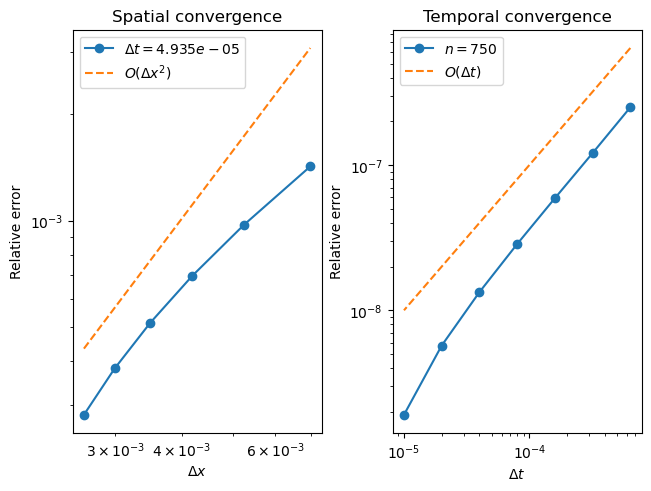

In [6]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
n_plot = np.array(n_plot)
dt_plot = np.array(dt_plot)
ax[0].loglog(np.pi/n_plot, space_errors, 'o-', label=f'$\Delta t = {dt_ref_space:.3e}$')
ax[0].loglog(np.pi/n_plot, (25/n_plot)**2, '--', label='$O(\Delta x^2)$')
ax[0].set_xlabel('$\Delta x$')
ax[0].set_ylabel('Relative error')
ax[0].set_title('Spatial convergence')
ax[1].loglog(dt_plot, time_errors, 'o-', label='$n=750$')
ax[1].loglog(dt_plot, 1e-3*dt_plot, '--', label='$O(\Delta t)$')
ax[1].set_xlabel('$\Delta t$')
ax[1].set_ylabel('Relative error')
ax[1].set_title('Temporal convergence')
ax[0].legend()
ax[1].legend()

In [7]:

#alpha = prey growth rate
#beta = predation rate
#delta = consumed prey to new predator growth
#gamma = predator mortality rate

def simp(n, dt, T=50.0, L=10.0, alpha=0.8, beta=0.125, delta=0.02, gamma=1.0, D_u=0.01, D_v=0.01):
    iter_curr = lambda delta_t, y, dx, t, A_package: trapezoid(f, delta_t, y, dx, t,A_package)
    x = np.linspace(0, np.pi, n + 1)
    u0 = 2+0.7*np.sin(3*np.pi*x/10)
    v0 = 1+0.3*np.sin(3*np.pi*x/10)
    U = solve_IBVP((u0, v0), n, dt, L, T, iter_curr)
    uT, vT = U[-1]
    return x[1:-1],uT, vT

Text(0.5, 0, 'X-position')

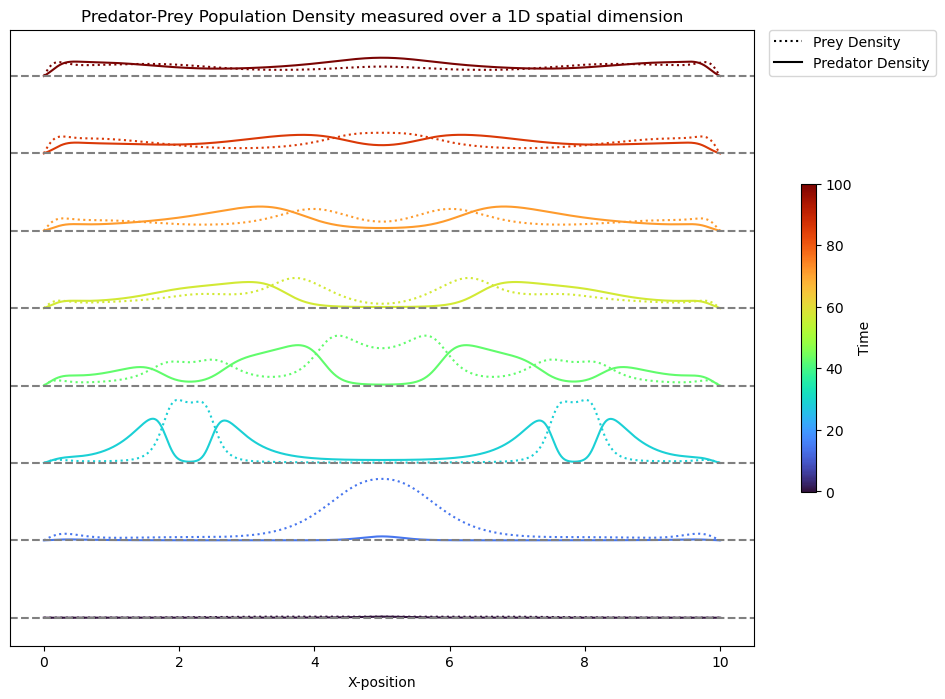

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(12,8))

n = 800; dt = 4e-4

def simp(n, dt, T=100, L=10.0, alpha=1, beta=0.5, delta=0.5, gamma=1, D_u=0.1, D_v=0.1):
    iter_curr = lambda delta_t, y, dx, t, A_package: trapezoid(f, delta_t, y, dx, t,A_package)
    x = np.linspace(0, 10, n + 1)
    u0 = (((0.3*(x-5))**8)+0.2)**-1 - (((0.3*(-5))**8)+0.2)**-1
    v0 = (((x-5)**2+0.2)**-1) - (((-5)**2 + 0.2)**-1)
    U = solve_IBVP((u0, v0), n, dt, L, T, iter_curr)
    return x,U

#x, U = simp(n, dt)

spacer = 1e-2
Nt = int(len(U))
idx = int(Nt/7)
colors = mpl.cm.turbo_r(np.linspace(0, 1, Nt))
t_vals = np.linspace(0, 100, Nt)

for i in range(Nt):
    if i%idx == 0:
        space = i*spacer
        u_vals, v_vals = U[i]
        u_vals = np.pad(u_vals,1,constant_values=0) + space
        v_vals = np.pad(v_vals,1,constant_values=0) + space
        plt.plot(x, u_vals, color = colors[-i-1], linestyle=':')
        plt.plot(x, v_vals, color = colors[-i-1], linestyle='-')
        plt.axhline(space, color='grey', linestyle='--')
ax = plt.gca(); ax.yaxis.set_visible(False)
cmap = mpl.cm.turbo
norm = mpl.colors.Normalize(vmin=t_vals.max(), vmax=t_vals.min())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


legend_handles = [
    Line2D([0], [0], color='black', linestyle=':', label='Prey Density'),
    Line2D([0], [0], color='black', linestyle='-', label='Predator Density')
]

plt.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0
)
plt.title('Predator-Prey Population Density measured over a 1D spatial dimension')
plt.colorbar(sm, ax=ax, label="Time", shrink=0.5)
plt.xlabel('X-position')

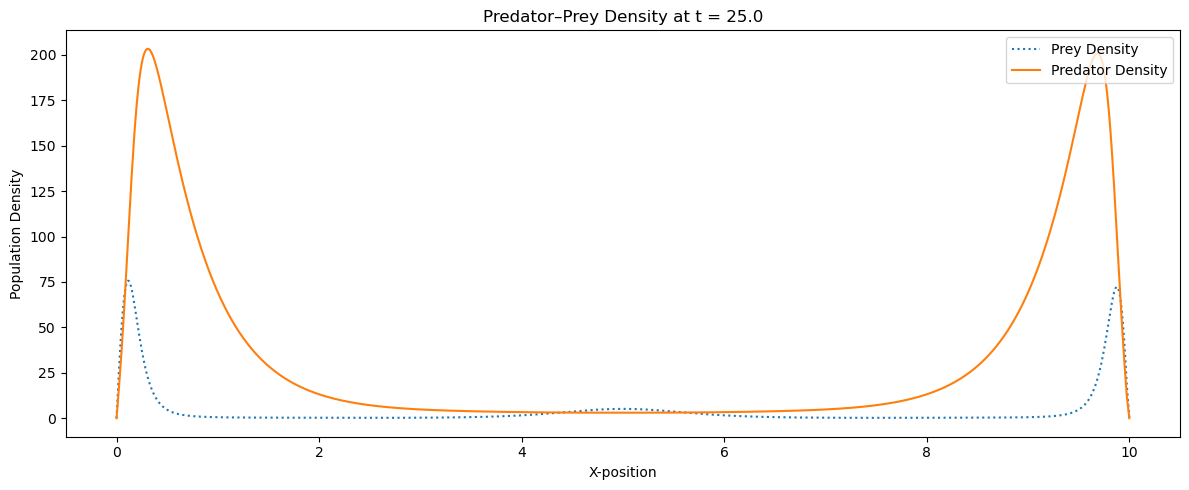

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# choose the physical time
# -----------------------------
t_target = 25.0   # time units (must be between 0 and T=500)

T = 250
Nt_full = len(U)
t_grid = np.linspace(0, T, Nt_full)

# find nearest time index
k = np.argmin(np.abs(t_grid - t_target))

# extract solution
u_vals, v_vals = U[k]
u_vals = np.pad(u_vals, 1, constant_values=0)
v_vals = np.pad(v_vals, 1, constant_values=0)

# -----------------------------
# plot
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(x, u_vals, linestyle=':', label='Prey Density')
plt.plot(x, v_vals, linestyle='-', label='Predator Density')

plt.xlabel('X-position')
plt.ylabel('Population Density')
plt.title(f'Predator–Prey Density at t = {t_grid[k]:.1f}')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

